# Household Electricity Consumption 

This is a multivariate time series analysis of power consumption which can be modeled to forecast electricity consumption. Objective of this project are as follows: - 

1. How to create and analysis autocorrelation and partial autocorrelation plots for univariate time series data. 
2. How to use the findings from autocorrelation plots to configure an autoregression model. 
3. How to develop and evaluate an autocorrelation model used to make one-week forecasts. 

This Project can be divided into 5 parts which are as follows: 
    1. Problem Description
    2. Load and Prepare Dataset
    3. Model Evaluation
    4. Autocorrelation Analysis 
    5. Develop an Autoregression Model

# Load and Prepare Dataset

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from numpy import nan
from numpy import isnan
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings

In [2]:
# Function to load the data. 
def load_data(file_path, seperator, date_col, time_col):
    
    # infer_datetime_format = if True, pandas will infer the format of the datetime strings in the columns. If this
    # is true, make sure parse_dates argument is enabled and mentioned in the code. 
    # parse_dates = parse the column in the list and call it as the keyword mentioned in the dictionary
    # index_col = Column to use as row number. In this case "datetime" is made as index. 
    data = pd.read_csv(file_path, sep = seperator ,header=0, low_memory=False,
                      infer_datetime_format=True, parse_dates={"datetime":[date_col,time_col]}, index_col=['datetime'])
    return data

#Function to replace unnecessary entries with Nan Values. 
def processing(data, replace_entry):
    data.replace(replace_entry, nan, inplace=True)
    data = data.astype('float32')
    
    return data

# Fill in the missing values. As it is time series data, any missing value is filled with the entry at the same time
# of previous day.

def fill_missing(data):
    
    values = data.values
    one_day = 60*24
    for row in range(values.shape[0]):
        for col in range(2,values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]
    ind = data.index
    col = data.columns.values
    df = pd.DataFrame(values, index= ind, columns=col)
    return df 

# Adding a column indicating power consumption apart from the power consumed in Kitchen, laundry room and 
# water heater and air conditioner

def add_column(data):
    values = data.values
    data['Sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
    return data

In [3]:
## Argument values for the function 
file_path = 'household_power_consumption.txt'
seperator = ";"
date_col = 0
time_col = 1
replace_entry = "?"

In [4]:
# Loading dataset
data = load_data(file_path=file_path, seperator=seperator, date_col=date_col, time_col=time_col)

#Processing by removing unwanted entires and converting each entry to numeric
data = processing(data, replace_entry=replace_entry)

# Filling all the missing values in the dataset
data = fill_missing(data)

# Adding an extra column displaying other power consumptions. 
data = add_column(data)

In [5]:
data.shape[0]

2075259

# Model Evaluation

In this section, we shall develop and evaluate predictive models for household power dataset. 
This section is divided into four section:- 
1. Problem Framing 
2. Evaluation Metric
3. Train and Test sets
4. Walk_forward Validation

In [6]:
daily_groups = data.resample("D")
daily_data = daily_groups.sum()

In [7]:
"""1) Problem Framing 
We shall explore very specific question that what is the expected power consumption for a week looking at the past
given power consumptions.Power consumption in our dataset is recorded at every minute, hence, we shall resample 
the dataset as per day. """

def resampling(data):
    daily_groups = data.resample("D")
    daily_data = daily_groups.sum()
    return daily_data


"""2 Evaluation Metric 
RMSE and MAE will be best fit to evaulate the total power consumption as they can have same error metric.
Evaluate one or more weekly forecasts against expected values"""

def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

"""3 Train and Test Dataset
We will use the first 3 years of data for training our model and final year to evaluate our model performance. 
split a univariate dataset into train/test sets """

def split_dataset(data):
    
    data = data.values
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

"""4 Walk-Forward Validation 
evaluate a single model"""
def evaluate_model(model_func, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

"""summarize scores"""
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [8]:
# Resampling the data
df = resampling(data)

# Spliting the dataset in Train and Test 
train , test = split_dataset(df)


# Autocorrelation Analysis

In [9]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
    # extract just the total power from each week
    series = [week[:, 0] for week in data]
    # flatten into a single series
    series = np.array(series).flatten()
    return series

In [11]:
# acf and pacf plots of total power

def acf_pacf_plot(data, lag):
    # lag = length of the graph

    
    from matplotlib import pyplot
    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.graphics.tsaplots import plot_pacf
    from matplotlib.pyplot import figure
    
    train , test = split_dataset(data)
    series = to_series(train)
    
    # plots

    pyplot.figure(num=None, figsize=(8, 6), dpi=500, facecolor='w', edgecolor='k')
    lags = lag
    # acf
    axis = pyplot.subplot(2, 1, 1)

    plot_acf(series, ax=axis, lags=lags)
    # pacf
    axis = pyplot.subplot(2, 1, 2)

    plot_pacf(series, ax=axis, lags=lags)
    # show plot
    pyplot.show()

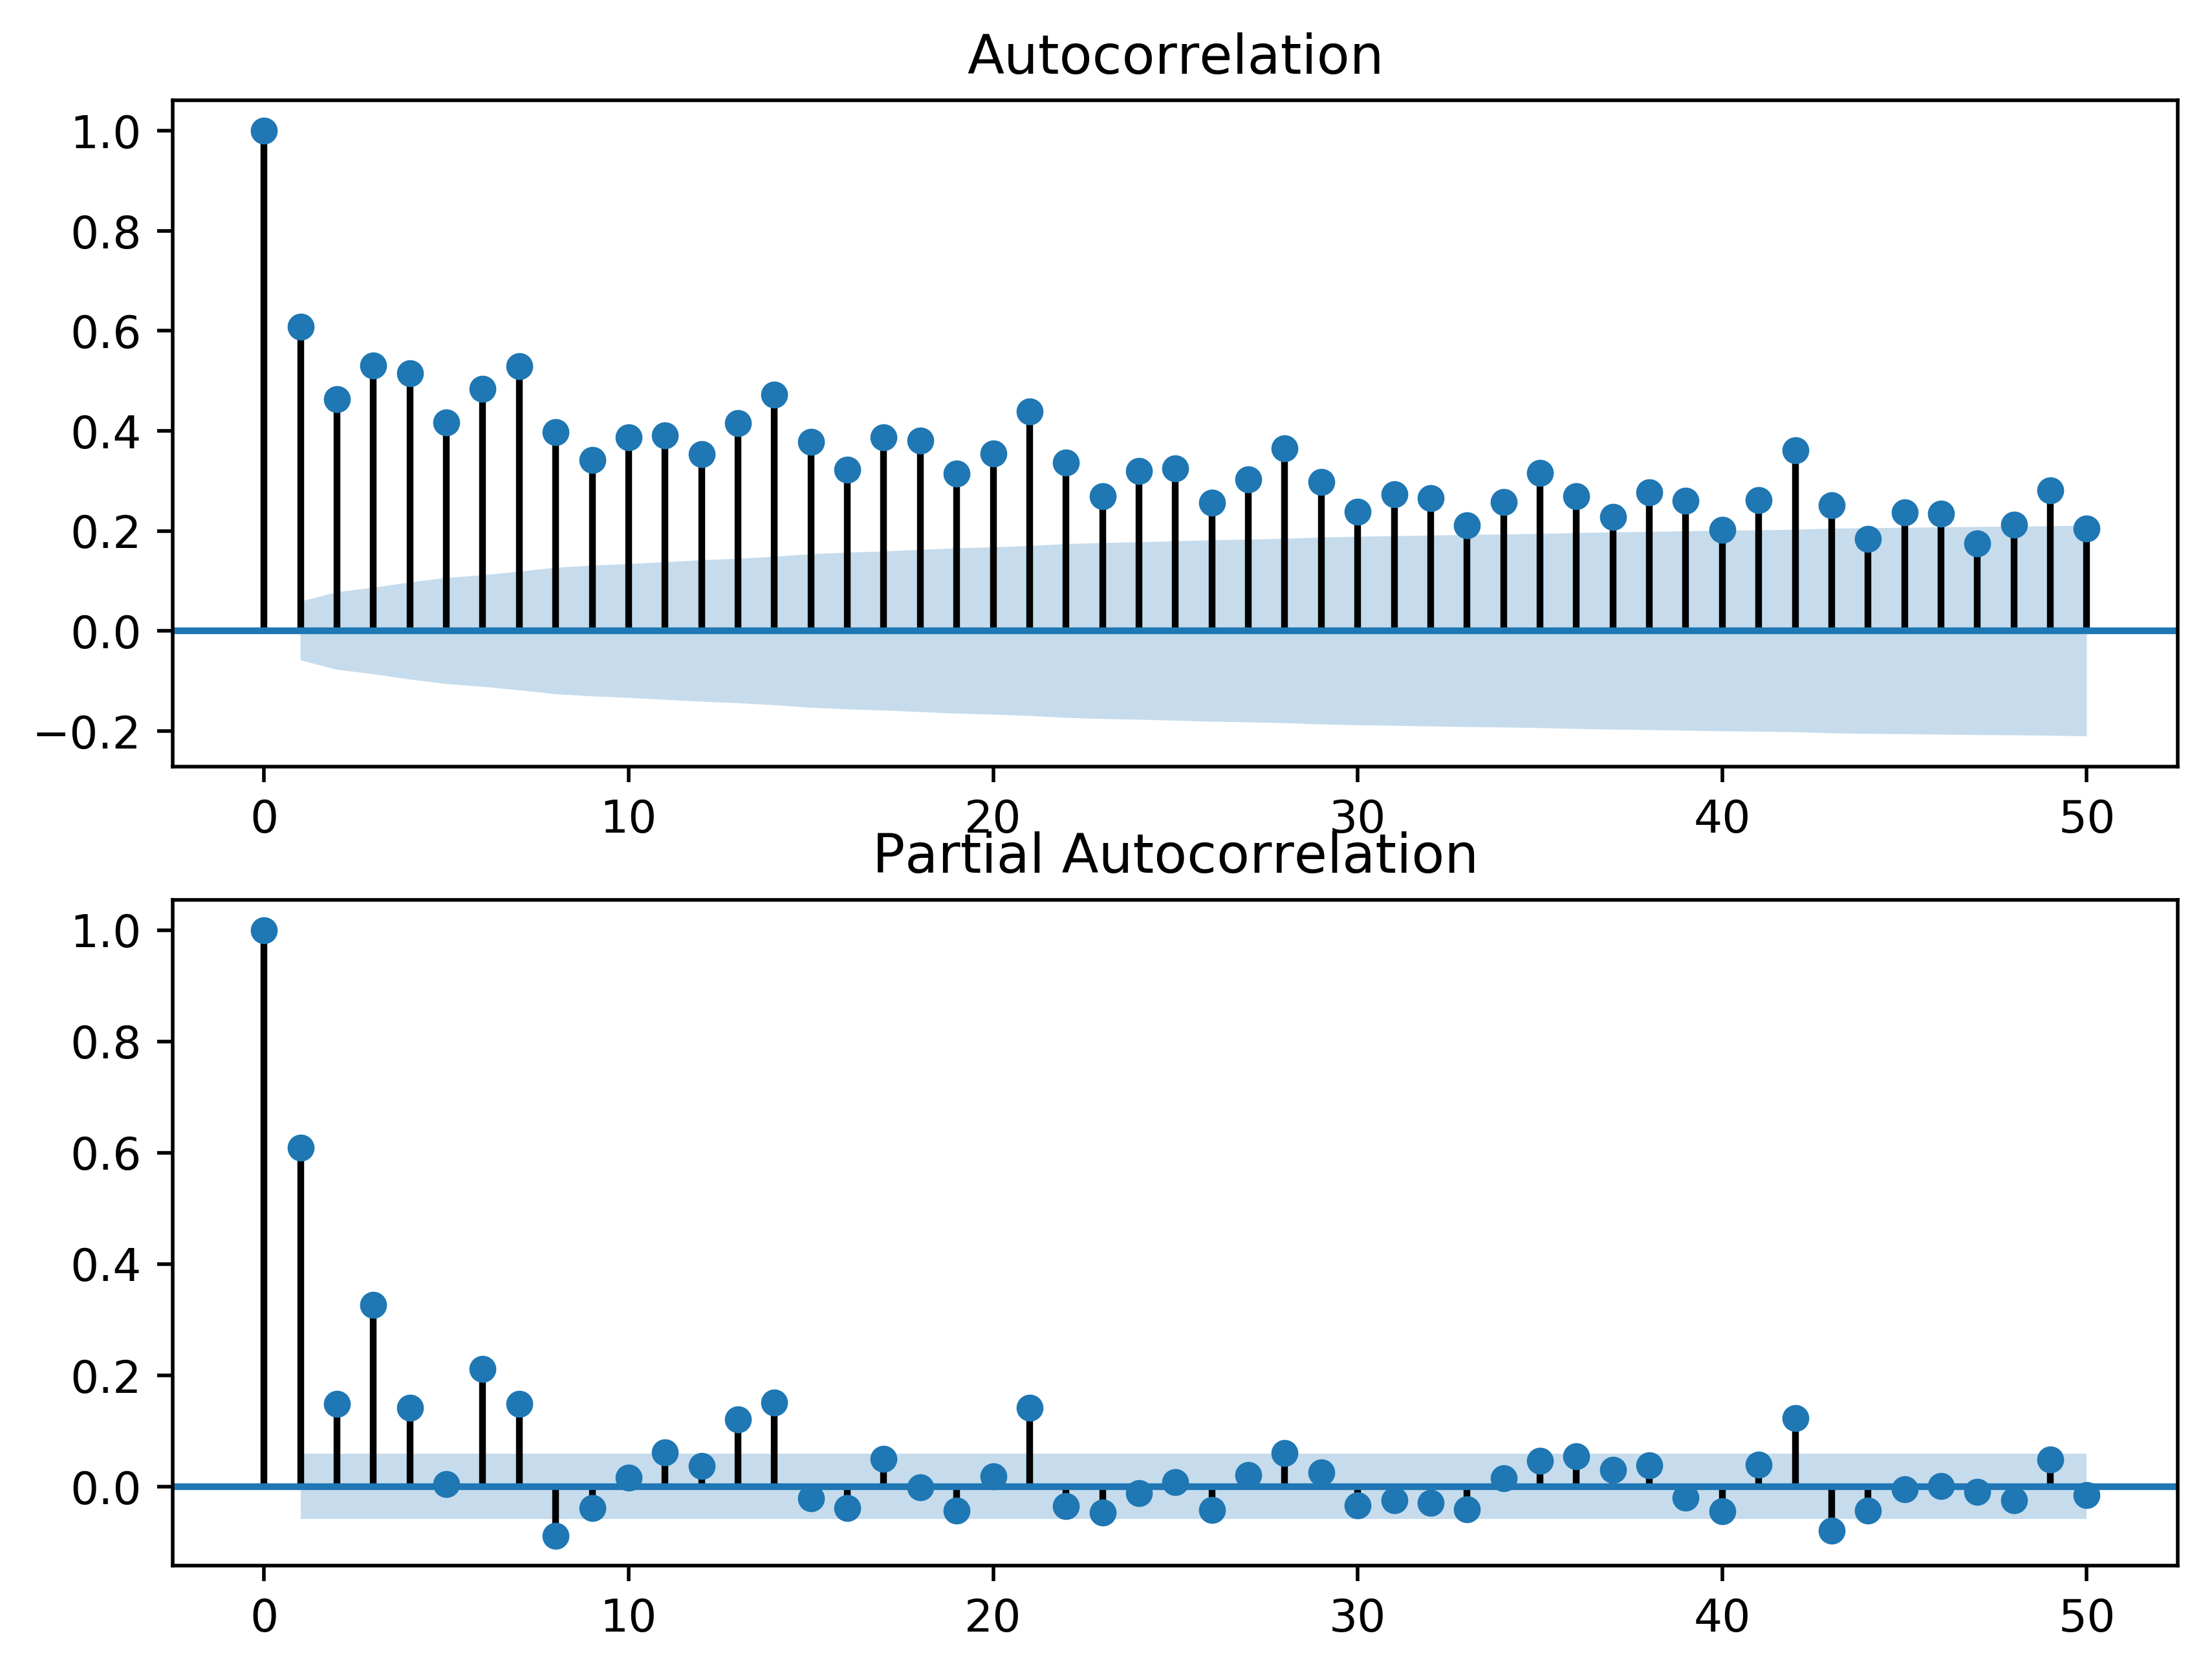

In [12]:
acf_pacf_plot(df, 50)


We can clearly see a familiar autoregression pattern across the two plots. This pattern is comprised of two elements:

ACF: A large number of significant lag observations that slowly degrade as the lag increases.
PACF: A few significant lag observations that abruptly drop as the lag increases.
The ACF plot indicates that there is a strong autocorrelation component, whereas the PACF plot indicates that this component is distinct for the first approximately seven lag observations.

This suggests that a good starting model would be an AR(7); that is an autoregression model with seven lag observations used as input.

# Develop an Autoregression Model

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

arima: [465.910] 428.1, 448.9, 395.8, 522.3, 450.5, 380.5, 597.9


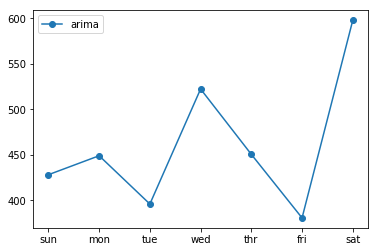

In [19]:
# arima forecast
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA



# arima forecast
def arima_forecast(history):
    # convert history into a univariate series
    series = to_series(history)
    # define the model
    model = ARIMA(series, order=(7,0,0))
    # fit the model
    model_fit = model.fit(disp=False)
    # make forecast
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

# load the new file
dataset = pd.read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, 
                      parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset)
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()